<a href="https://colab.research.google.com/github/GallardoCoriaMarcelo/Laboratorios/blob/main/Ej02_Ev_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episodio: 100 - Recompensa: 1.1111111111111112
Episodio: 200 - Recompensa: -1.0
Episodio: 300 - Recompensa: 2.2222222222222223
Episodio: 400 - Recompensa: -1.0
Episodio: 500 - Recompensa: 1.1111111111111112
Estado del rompecabezas al final del episodio 500:
 1  4  5
 8  6  0
 3  7  2

Episodio: 600 - Recompensa: 2.2222222222222223
Episodio: 700 - Recompensa: -1.0
Episodio: 800 - Recompensa: 1.1111111111111112
Episodio: 900 - Recompensa: 2.2222222222222223
Episodio: 1000 - Recompensa: 1.1111111111111112
Estado del rompecabezas al final del episodio 1000:
 8  7  0
 1  3  6
 5  2  4

Episodio: 1100 - Recompensa: 1.1111111111111112
Episodio: 1200 - Recompensa: 1.1111111111111112
Episodio: 1300 - Recompensa: 1.1111111111111112
Episodio: 1400 - Recompensa: 2.2222222222222223
Episodio: 1500 - Recompensa: 4.444444444444445
Estado del rompecabezas al final del episodio 1500:
 1  2  0
 4  3  7
 6  8  5

Episodio: 1600 - Recompensa: 2.2222222222222223
Episodio: 1700 - Recompensa: 2.22222222222222

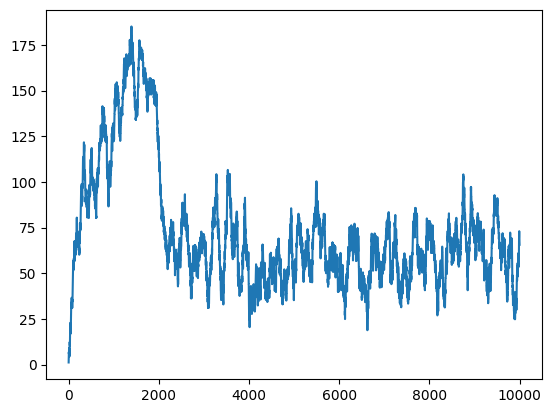

In [26]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces

#CREACION DEL ENTORNO PUZZLE
class PuzzleEnv(gym.Env):
    def __init__(self, rows=3, cols=3):
        super(PuzzleEnv, self).__init__()
        self.rows = rows
        self.cols = cols
        self.n_tiles = rows * cols
        self.action_space = spaces.Discrete(4)  # Arriba, Abajo, Izquierda, Derecha
        self.observation_space = spaces.Box(low=0, high=self.n_tiles-1, shape=(self.n_tiles,), dtype=np.int32)
        self.reset()

#ESTADO INICIAL DEL ENTORNO
    def reset(self):
        self.tiles = list(range(1, self.n_tiles)) + [0]
        np.random.shuffle(self.tiles)
        self.tiles = np.array(self.tiles).reshape((self.rows, self.cols))
        self.empty_pos = np.argwhere(self.tiles == 0)[0]
        return self.tiles.flatten(), {}

#MOVIMIENTOS DEL AGENTE
    def step(self, action):
        if action == 0:  # Arriba
            move = (-1, 0)
        elif action == 1:  # Abajo
            move = (1, 0)
        elif action == 2:  # Izquierda
            move = (0, -1)
        elif action == 3:  # Derecha
            move = (0, 1)
        else:
            raise ValueError("Acción inválida")

#NUEVA POSICION VERIFICACION
        new_pos = self.empty_pos + move
        if 0 <= new_pos[0] < self.rows and 0 <= new_pos[1] < self.cols:
            self.tiles[self.empty_pos[0], self.empty_pos[1]], self.tiles[new_pos[0], new_pos[1]] = self.tiles[new_pos[0], new_pos[1]], self.tiles[self.empty_pos[0], self.empty_pos[1]]
            self.empty_pos = new_pos

        done = np.array_equal(self.tiles.flatten(), np.arange(1, self.n_tiles+1)) or np.array_equal(self.tiles.flatten(), np.concatenate((np.arange(1, self.n_tiles), [0])))

        # Calcular la recompensa gradual
        reward = self.calculate_reward()

        return self.tiles.flatten(), reward, done, done, {}

#CALCULO DE RECOMPENSAS GRADUALES, POR FICHA CORRECTA
    def calculate_reward(self):
        correct_positions = np.sum(self.tiles.flatten() == np.arange(1, self.n_tiles+1))
        reward = (correct_positions / self.n_tiles) * 10  # 10% de recompensa por cada ficha correcta
        return reward if reward > 0 else -1

    def render(self, mode='human'):
        for row in self.tiles:
            print(" ".join(f"{tile:2d}" for tile in row))
        print()

env = PuzzleEnv()
# Registro del entorno personalizado
gym.register(
    id='PuzzleEnv-v0',
    entry_point=PuzzleEnv,
    max_episode_steps=100
)

#ENTRENAMIENTO DEL MODELO
def entrenar(_episodios):
    entorno = gym.make('PuzzleEnv-v0')

    q_tabla = np.zeros((entorno.observation_space.shape[0], entorno.action_space.n))

    ratio_aprendizaje = 0.05
    factor_descuento = 0.99
    epsilon = 1
    ratio_decaimiento_epsilon = 0.0005
    rango = np.random.default_rng()

    ep = 0
    recompensa_por_episodio = np.zeros(_episodios)

#BUCLE DE EPISODIOS
    for i in range(_episodios):
        ep += 1
        if (i + 1) % 500 == 0:
            entorno.close()
            entorno = gym.make('PuzzleEnv-v0')

        else:
            entorno.close()
            entorno = gym.make('PuzzleEnv-v0')

        estado = entorno.reset()[0]

        terminado = False
        truncado = False

#VERFIFICACION DE JUEGO NO TERMINADO
        while (not terminado and not truncado):

            if (rango.random() < epsilon):
                accion = entorno.action_space.sample()
            else:
                accion = np.argmax(q_tabla[estado, :])

            nuevo_estado, recompensa, terminado, truncado, _ = entorno.step(accion)
            q_tabla[estado, accion] = q_tabla[estado, accion] + ratio_aprendizaje * (recompensa + factor_descuento * np.max(q_tabla[nuevo_estado, :]) - q_tabla[estado, accion])

            estado = nuevo_estado

        epsilon = max(epsilon - ratio_decaimiento_epsilon, 0)

#RECOMPENSAS POR EPISODIO
        recompensa_por_episodio[i] = recompensa

        if (i + 1) % 100 == 0:
            print(f"Episodio: {i + 1} - Recompensa: {recompensa_por_episodio[i]}")

#ESTADO DEL ENTORNO CADA 500 EPISODIOS
        if (i + 1) % 500 == 0:
            print(f"Estado del rompecabezas al final del episodio {i + 1}:")
            entorno.render()

    entorno.close()
    print(f"Mejor Q: {q_tabla}")

    suma_recompensas = np.zeros(_episodios)
    for t in range(_episodios):
        suma_recompensas[t] = np.sum(recompensa_por_episodio[max(0, t - 100):(t + 1)])

    plt.plot(suma_recompensas)
    plt.show()

if __name__ == '__main__':
    entrenar(10000)

